In [1]:
import torch
from torch.autograd import Variable
dtype = torch.FloatTensor

In [2]:
import numpy as np
pi = np.pi
%matplotlib notebook
import matplotlib.pyplot as plt

## Simultaneous search for policy and verifying Lyapunov function

$$\dot{x} = f(x,u)$$

$$ u = \pi_\theta(x)) $$

$$ V(x) = p.s.d. \text{by construction, but parameterized by parameters } \psi $$

$$ \dot{V} = \frac{dV}{dx} \dot{x}$$
$$ = \big[ \frac{dV}{dx}\big]^T \big[f(x,\pi_{\theta}(x) \big] $$

### Loss function

$X$ = {$x_1, x_2, ..., x_N$} many samples

$$ L(\theta) = \sum_{i} l(x_i, \theta) $$

\begin{equation}
  \mathcal{l}(x_i,\theta) =
  \begin{cases}
    \dot{V}(x_i, \theta) & \text{if $\dot{V}(x_i, \theta) > 0$} \\
    0 & \text{otherwise}
  \end{cases}
\end{equation}



In [3]:
l = 1.0   # length in pixels
g = 1.0    # gravity in m/s**2
m = 1.0    # mass in kg
b = 1.0    # damping

x_i = Variable(torch.FloatTensor([1.0, 1.1]).type(dtype), requires_grad=True)
print x_i

P = Variable(torch.FloatTensor([1, 1]).type(dtype), requires_grad=True)
print P
### Step 1: compute V(x)
def compute_V(x):
    '''V(x) = x_1^2 + x_2^2'''
    x_desired = Variable(torch.FloatTensor([0, 0]).type(dtype), requires_grad=False)
    x_squared = (x-x_desired).pow(2)
    return torch.dot(P, x_squared)

def compute_V_energy_based(x):
    '''V(x) = (E - E_d)^2'''
    energy = 0.5*m*l**2*x[1]**2 + m*g*l*torch.cos(x[0])
    energy_desired = m*g*l
    difference_squared = (energy-energy_desired).pow(2)
    return difference_squared

print x_i.shape
print "V is", compute_V_energy_based(x_i)
x_i_2 = Variable(torch.FloatTensor([1.1, 2.2]).type(dtype), requires_grad=True)
print "V is", compute_V_energy_based(x_i_2)

many_x_i = Variable(torch.FloatTensor([[1.0, 1.1, 2.0],[1.1, 2.2, 3.0]]).type(dtype), requires_grad=True)

def compute_V_vectorized(x):
    x_desired = Variable(torch.FloatTensor([0, 0]).type(dtype), requires_grad=False)
    x_desired_vectorized = torch.t(x_desired.repeat(x.shape[1], 1))
    x_squared = (x-x_desired_vectorized).pow(2)
    P_transpose = torch.t(P.unsqueeze(1))
    return P_transpose.mm(x_squared)

def compute_V_energy_based_vectorized(x):
    energy_vectorized = 0.5*m*l**2*x[1,:].pow(2) + m*g*l*torch.cos(x[0,:])
    energy_desired = m*g*l
    difference_squared = (energy_vectorized-energy_desired).pow(2)
    return difference_squared
    
print many_x_i
print compute_V_energy_based_vectorized(many_x_i)

Variable containing:
 1.0000
 1.1000
[torch.FloatTensor of size 2]

Variable containing:
 1
 1
[torch.FloatTensor of size 2]

torch.Size([2])
V is Variable containing:
1.00000e-02 *
  2.1113
[torch.FloatTensor of size 1]

V is Variable containing:
 3.5104
[torch.FloatTensor of size 1]

Variable containing:
 1.0000  1.1000  2.0000
 1.1000  2.2000  3.0000
[torch.FloatTensor of size 2x3]

Variable containing:
 0.0211
 3.5104
 9.5102
[torch.FloatTensor of size 3]



In [4]:
### Step 2: compute dV/dx

### Step 3: initialize policy parameters
# K = Variable(torch.FloatTensor([1, 2]).type(dtype), requires_grad=True)
# print K

### Step 4: define dynamics function
def dynamics(x):
    xdot = Variable(torch.zeros(2).type(dtype))
    xdot[0] = x[1]
    xdot[1] = -torch.dot(K,x)
    return xdot

def pendulum_policy(x):
    x_desired = Variable(torch.FloatTensor([0, 0]).type(dtype), requires_grad=False)
    return -torch.dot(K,x-x_desired)

def pendulum_energy_policy(x):
    energy = 0.5*m*l**2*x[1]**2 + m*g*l*torch.cos(x[0])
    energy_desired = m*g*l
    return -1*x[1]*(energy - energy_desired)

K_size = 3
#K = torch.randn(K_size)
#K = Variable(K, requires_grad=True)
K = Variable(torch.FloatTensor([0.5*m*l**2, m*g*l, -m*g*l]).type(dtype), requires_grad=True)
def pendulum_policy_search(x):
    monomials = Variable(torch.zeros(K_size))
    monomials[0] = x[1].pow(3)
    print "x is", x
    monomials[1] = x[1]*torch.cos(x[0])
    monomials[2] = x[1].pow(3)
    print "monomials is", monomials
    u = torch.dot(K, monomials)
    return u

def pendulum_dynamics(x):
    xdot = Variable(torch.zeros(2).type(dtype))
    xdot[0] = x[1]
    u = pendulum_energy_policy(x)
    xdot[1] = (m * g * l * torch.sin(x[0:1])) + u
    return xdot
    
xdot = pendulum_dynamics(x_i)
print xdot
print pendulum_dynamics(x_i_2)
print "policy search is", pendulum_policy_search(x_i)
print "policy search is", pendulum_policy_search(x_i_2)

many_x_i = Variable(torch.FloatTensor([[1.0, 1.1, 2.0],[1.1, 2.2, 3.0]]).type(dtype), requires_grad=True)

def dynamics_vectorized(x):
    xdot = Variable(torch.zeros(2,x.shape[1]).type(dtype))
    xdot[0,:] = x[1,:]
    K_transpose = torch.t(K.unsqueeze(1))
    xdot[1,:] = -K_transpose.mm(x)
    return xdot

def pendulum_policy_vectorized(x):
    x_desired = Variable(torch.FloatTensor([0, 0]).type(dtype), requires_grad=False)
    x_desired_vectorized = torch.t(x_desired.repeat(x.shape[1], 1))
    K_transpose = torch.t(K.unsqueeze(1))
    return K_transpose.mm(x - x_desired_vectorized)

def pendulum_energy_policy_vectorized(x):
    energy_vectorized = 0.5*m*l**2*x[1,:]**2 + m*g*l*torch.cos(x[0,:])
    energy_desired = m*g*l
    return -K[0]*x[1,:]*(energy_vectorized - energy_desired)

def pendulum_policy_search_vectorized(x):
    monomials = Variable(torch.zeros(K_size, x.shape[1]))
    monomials[0] = x[1,:]
    monomials[1] = x[1,:].pow(3)
    monomials[2] = x[1,:]*torch.cos(x[0,:])
    K_transpose = torch.t(K.unsqueeze(1))
    return -K_transpose.mm(monomials)

def pendulum_dynamics_vectorized(x):
    xdot = Variable(torch.zeros(2,x.shape[1]).type(dtype))
    xdot[0,:] = x[1,:]
    u = pendulum_policy_search_vectorized(x)
    xdot[1,:] = (m * g * l * torch.sin(x[0:1])) + u
    return xdot
      
print many_x_i
print pendulum_dynamics_vectorized(many_x_i)
print "policy search is", pendulum_policy_search_vectorized(many_x_i)

Variable containing:
 1.1000
 0.6816
[torch.FloatTensor of size 2]

Variable containing:
 2.2000
-3.2307
[torch.FloatTensor of size 2]

policy search is x is Variable containing:
 1.0000
 1.1000
[torch.FloatTensor of size 2]

monomials is Variable containing:
 1.3310
 0.5943
 1.3310
[torch.FloatTensor of size 3]

Variable containing:
1.00000e-02 *
 -7.1167
[torch.FloatTensor of size 1]

policy search is x is Variable containing:
 1.1000
 2.2000
[torch.FloatTensor of size 2]

monomials is Variable containing:
 10.6480
  0.9979
 10.6480
[torch.FloatTensor of size 3]

Variable containing:
-4.3261
[torch.FloatTensor of size 1]

Variable containing:
 1.0000  1.1000  2.0000
 1.1000  2.2000  3.0000
[torch.FloatTensor of size 2x3]

Variable containing:
  1.1000   2.2000   3.0000
 -0.4452  -9.8589 -28.8391
[torch.FloatTensor of size 2x3]

policy search is Variable containing:
 -1.2867 -10.7501 -29.7484
[torch.FloatTensor of size 1x3]



In [5]:
## COMPARE ENERGY POLICY

print "energy computes", pendulum_energy_policy(x_i)
print "search computes", pendulum_policy_search(x_i)

energy computes Variable containing:
-0.1598
[torch.FloatTensor of size 1]

search computes x is Variable containing:
 1.0000
 1.1000
[torch.FloatTensor of size 2]

monomials is Variable containing:
 1.3310
 0.5943
 1.3310
[torch.FloatTensor of size 3]

Variable containing:
1.00000e-02 *
 -7.1167
[torch.FloatTensor of size 1]



In [6]:
def compute_Vdot(x):
    V = compute_V_energy_based(x)
#     print x.shape
#     print V.shape
#     print V
    V.backward(torch.ones(1).type(dtype),retain_graph=True)
#     print "x.grad is", x.grad
    jacobian_x = Variable(x.grad.data)
#     print "jacobian_x is", jacobian_x
    f = pendulum_dynamics(x)
    Vdot = torch.dot(jacobian_x,f)
    return Vdot

print "x_i is", x_i
if x_i.grad is not None:
    print x_i.grad.zero_()
Vdot = compute_Vdot(x_i)
print "Vdot is", Vdot
Vdot.backward()

def compute_Vdot_vectorized(x):
    V = compute_V_energy_based_vectorized(x)
#     print V
#     print x.shape
#     print "x.grad is", x.grad
#    V.backward(torch.ones(1,1).type(dtype),retain_graph=True)
#     print x
    V.backward(torch.ones(1,x.shape[1]).type(dtype),retain_graph=True)
    jacobian_x = Variable(x.grad.data)
#     print "jacobian_x is", jacobian_x
    f = pendulum_dynamics_vectorized(x)
    Vdot = (jacobian_x*f).sum(dim=0)
    return Vdot

print "many_x_i is", many_x_i

Vdot_vec = compute_Vdot_vectorized(many_x_i)
print "Vdot_vec is", Vdot_vec
#Vdot.backward(torch.ones(many_x_i.shape[1]).type(dtype))
cost = Vdot_vec.clamp(min=0).sum()
print cost
cost.backward()
many_x_i.grad.data.zero_()



x_i is Variable containing:
 1.0000
 1.1000
[torch.FloatTensor of size 2]

Vdot is Variable containing:
1.00000e-02 *
 -5.1093
[torch.FloatTensor of size 1]

many_x_i is Variable containing:
 1.0000  1.1000  2.0000
 1.1000  2.2000  3.0000
[torch.FloatTensor of size 2x3]

Vdot_vec is Variable containing:
  -0.4113
 -88.6218
-550.4390
[torch.FloatTensor of size 3]

Variable containing:
 0
[torch.FloatTensor of size 1]




 0  0  0
 0  0  0
[torch.FloatTensor of size 2x3]

## First let's verify, no synthesis
 
K = [1, 2] and P = [1, 1] should be stable

In [7]:
#K = Variable(torch.FloatTensor([1, 2]).type(dtype), requires_grad=True)
P = Variable(torch.FloatTensor([1, 1]).type(dtype), requires_grad=True)
for i in range(10000):
    x_i = Variable(torch.randn(2).type(dtype), requires_grad=True)
    Vdot = compute_Vdot(x_i)
    if Vdot.data[0] > 0:
        print "false, counterexample found: ", x_i
        print i
        print compute_V(x_i)
        print Vdot.data[0]
        break

## Now let's search for K, from an initialization not stable

In [8]:
P = Variable(torch.rand(2).type(dtype), requires_grad=True)
#K = Variable(torch.randn(2).type(dtype), requires_grad=True)

print "Initial P", P
print "Initial K", K


for i in range(10000):
    x_i = Variable(torch.randn(2).type(dtype), requires_grad=True)
    Vdot = compute_Vdot(x_i)
    if Vdot.data[0] > 0:
        print "false, counterexample found: ", x_i
        break

Initial P Variable containing:
 0.8143
 0.8011
[torch.FloatTensor of size 2]

Initial K Variable containing:
 0.5000
 1.0000
-1.0000
[torch.FloatTensor of size 3]



In [9]:
# Reset 
P = Variable(torch.rand(2).type(dtype), requires_grad=True)
#K = Variable(torch.randn(2).type(dtype), requires_grad=True)

<IPython.core.display.Javascript object>


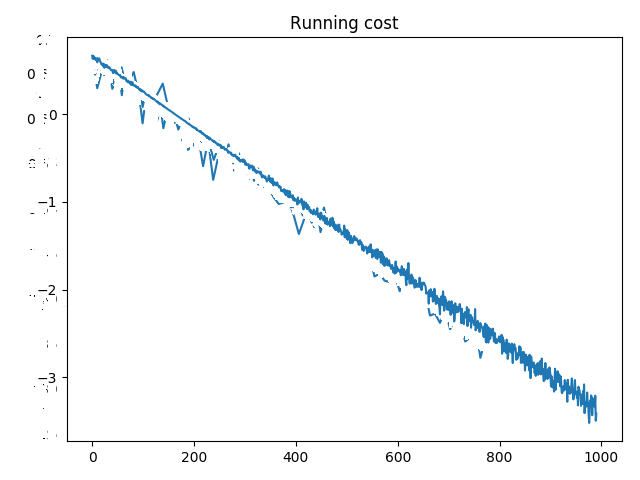

In [10]:
## optimization plotting tool

cost_current_iteration = 0
cost_history = []
cost_iteration_number_history = []

f, (cost_axis) = plt.subplots(1, 1)

cost_axis.plot(cost_iteration_number_history, cost_history)
cost_axis.set_title('Running cost')

plt.tight_layout()

In [11]:
## optimize

num_iterations = 1000
num_samples_per_iteration = 10000
step_rate = 1e-3
slack_var = .01

# K has already been initialized above, and initial policy visualized

import time
print "first P is", P
print "first K is", K

for cost_iteration in range(num_iterations):
    
    start = time.time()
    
    cost = 0
    
    samples = 0.2*(torch.rand(2,num_samples_per_iteration).type(dtype)*2 - torch.ones(2,num_samples_per_iteration))
    many_x_i = Variable(samples, requires_grad=True)
    Vdot = compute_Vdot_vectorized(many_x_i)
    cost = Vdot.clamp(min=-slack_var).sum()
        
    ## Automatically differentiate
    cost.backward()

    # Update K via gradient descent
    K.data -= step_rate * K.grad.data
    #P.data -= step_rate * P.grad.data
    
    # Project P into feasible
    #P.data = torch.abs(P.data)
    # Make P numerically stable by normalizing
    #P.data = P.data/(P.data.pow(2).sum())
      
    # Manually zero the gradients after running the backward pass
    K.grad.data.zero_()
    #P.grad.data.zero_()
    
    print time.time() - start, "is time for one step of grad descent"
    print 
    print cost.data[0]
    
    # handle plotting
    cost_history.append(cost.data[0])
    cost_iteration_number_history.append(cost_iteration)
    
    if cost_iteration % 10 == 0:
        cost_axis.lines[0].set_xdata(cost_iteration_number_history)
        cost_axis.lines[0].set_ydata(cost_history)
        cost_axis.relim()
        cost_axis.autoscale_view()
        cost_axis.figure.canvas.draw()
        
    if cost.data[0] == 0:
        break
        
    print "P is", P
    print "K is", K
    
    if cost_iteration == num_iterations - 1:
        print "didn't converge"

first P is Variable containing:
 0.1539
 0.9287
[torch.FloatTensor of size 2]

first K is Variable containing:
 0.5000
 1.0000
-1.0000
[torch.FloatTensor of size 3]

0.0116980075836 is time for one step of grad descent

0.669658839703
P is Variable containing:
 0.1539
 0.9287
[torch.FloatTensor of size 2]

K is Variable containing:
 0.5014
 1.0000
-0.9986
[torch.FloatTensor of size 3]

0.00553703308105 is time for one step of grad descent

0.633485794067
P is Variable containing:
 0.1539
 0.9287
[torch.FloatTensor of size 2]

K is Variable containing:
 0.5028
 1.0001
-0.9972
[torch.FloatTensor of size 3]

0.00445699691772 is time for one step of grad descent

0.654744803905
P is Variable containing:
 0.1539
 0.9287
[torch.FloatTensor of size 2]

K is Variable containing:
 0.5042
 1.0001
-0.9958
[torch.FloatTensor of size 3]

0.004478931427 is time for one step of grad descent

0.664496898651
P is Variable containing:
 0.1539
 0.9287
[torch.FloatTensor of size 2]

K is Variable containi

0.0036518573761 is time for one step of grad descent

0.42419475317
P is Variable containing:
 0.1539
 0.9287
[torch.FloatTensor of size 2]

K is Variable containing:
 0.5810
 1.0028
-0.9190
[torch.FloatTensor of size 3]

0.0020649433136 is time for one step of grad descent

0.427121043205
P is Variable containing:
 0.1539
 0.9287
[torch.FloatTensor of size 2]

K is Variable containing:
 0.5824
 1.0028
-0.9176
[torch.FloatTensor of size 3]

0.00218510627747 is time for one step of grad descent

0.419556289911
P is Variable containing:
 0.1539
 0.9287
[torch.FloatTensor of size 2]

K is Variable containing:
 0.5838
 1.0029
-0.9162
[torch.FloatTensor of size 3]

0.0020809173584 is time for one step of grad descent

0.417968034744
P is Variable containing:
 0.1539
 0.9287
[torch.FloatTensor of size 2]

K is Variable containing:
 0.5852
 1.0029
-0.9148
[torch.FloatTensor of size 3]

0.00211906433105 is time for one step of grad descent

0.426436841488
P is Variable containing:
 0.1539
 0.9

P is Variable containing:
 0.1539
 0.9287
[torch.FloatTensor of size 2]

K is Variable containing:
 0.6584
 1.0054
-0.8416
[torch.FloatTensor of size 3]

0.00274777412415 is time for one step of grad descent

0.210884779692
P is Variable containing:
 0.1539
 0.9287
[torch.FloatTensor of size 2]

K is Variable containing:
 0.6598
 1.0055
-0.8402
[torch.FloatTensor of size 3]

0.00236105918884 is time for one step of grad descent

0.215389505029
P is Variable containing:
 0.1539
 0.9287
[torch.FloatTensor of size 2]

K is Variable containing:
 0.6613
 1.0055
-0.8387
[torch.FloatTensor of size 3]

0.00225400924683 is time for one step of grad descent

0.203094884753
P is Variable containing:
 0.1539
 0.9287
[torch.FloatTensor of size 2]

K is Variable containing:
 0.6627
 1.0056
-0.8373
[torch.FloatTensor of size 3]

0.00221514701843 is time for one step of grad descent

0.200763061643
P is Variable containing:
 0.1539
 0.9287
[torch.FloatTensor of size 2]

K is Variable containing:
 0.66

0.00369811058044 is time for one step of grad descent

-0.0481325052679
P is Variable containing:
 0.1539
 0.9287
[torch.FloatTensor of size 2]

K is Variable containing:
 0.7513
 1.0086
-0.7488
[torch.FloatTensor of size 3]

0.00252103805542 is time for one step of grad descent

-0.0522255636752
P is Variable containing:
 0.1539
 0.9287
[torch.FloatTensor of size 2]

K is Variable containing:
 0.7527
 1.0087
-0.7473
[torch.FloatTensor of size 3]

0.00236701965332 is time for one step of grad descent

-0.0561275072396
P is Variable containing:
 0.1539
 0.9287
[torch.FloatTensor of size 2]

K is Variable containing:
 0.7541
 1.0087
-0.7459
[torch.FloatTensor of size 3]

0.0024049282074 is time for one step of grad descent

-0.0602157264948
P is Variable containing:
 0.1539
 0.9287
[torch.FloatTensor of size 2]

K is Variable containing:
 0.7555
 1.0088
-0.7445
[torch.FloatTensor of size 3]

0.00255584716797 is time for one step of grad descent

-0.0640570372343
P is Variable containing:

0.00291299819946 is time for one step of grad descent

-0.306589692831
P is Variable containing:
 0.1539
 0.9287
[torch.FloatTensor of size 2]

K is Variable containing:
 0.8439
 1.0118
-0.6561
[torch.FloatTensor of size 3]

0.00225210189819 is time for one step of grad descent

-0.320057928562
P is Variable containing:
 0.1539
 0.9287
[torch.FloatTensor of size 2]

K is Variable containing:
 0.8454
 1.0118
-0.6547
[torch.FloatTensor of size 3]

0.0019679069519 is time for one step of grad descent

-0.319493442774
P is Variable containing:
 0.1539
 0.9287
[torch.FloatTensor of size 2]

K is Variable containing:
 0.8468
 1.0119
-0.6532
[torch.FloatTensor of size 3]

0.00196194648743 is time for one step of grad descent

-0.32134398818
P is Variable containing:
 0.1539
 0.9287
[torch.FloatTensor of size 2]

K is Variable containing:
 0.8482
 1.0119
-0.6518
[torch.FloatTensor of size 3]

0.00203609466553 is time for one step of grad descent

-0.334519118071
P is Variable containing:
 0.15

P is Variable containing:
 0.1539
 0.9287
[torch.FloatTensor of size 2]

K is Variable containing:
 0.9291
 1.0147
-0.5709
[torch.FloatTensor of size 3]

0.0028350353241 is time for one step of grad descent

-0.57538241148
P is Variable containing:
 0.1539
 0.9287
[torch.FloatTensor of size 2]

K is Variable containing:
 0.9306
 1.0148
-0.5694
[torch.FloatTensor of size 3]

0.00274896621704 is time for one step of grad descent

-0.5541228652
P is Variable containing:
 0.1539
 0.9287
[torch.FloatTensor of size 2]

K is Variable containing:
 0.9320
 1.0148
-0.5680
[torch.FloatTensor of size 3]

0.00327086448669 is time for one step of grad descent

-0.568506479263
P is Variable containing:
 0.1539
 0.9287
[torch.FloatTensor of size 2]

K is Variable containing:
 0.9334
 1.0149
-0.5666
[torch.FloatTensor of size 3]

0.00313997268677 is time for one step of grad descent

-0.577945411205
P is Variable containing:
 0.1539
 0.9287
[torch.FloatTensor of size 2]

K is Variable containing:
 0.93

P is Variable containing:
 0.1539
 0.9287
[torch.FloatTensor of size 2]

K is Variable containing:
 1.0286
 1.0181
-0.4715
[torch.FloatTensor of size 3]

0.00197005271912 is time for one step of grad descent

-0.872623562813
P is Variable containing:
 0.1539
 0.9287
[torch.FloatTensor of size 2]

K is Variable containing:
 1.0300
 1.0182
-0.4700
[torch.FloatTensor of size 3]

0.00184416770935 is time for one step of grad descent

-0.868971943855
P is Variable containing:
 0.1539
 0.9287
[torch.FloatTensor of size 2]

K is Variable containing:
 1.0315
 1.0182
-0.4685
[torch.FloatTensor of size 3]

0.00183200836182 is time for one step of grad descent

-0.863086879253
P is Variable containing:
 0.1539
 0.9287
[torch.FloatTensor of size 2]

K is Variable containing:
 1.0329
 1.0183
-0.4671
[torch.FloatTensor of size 3]

0.00184798240662 is time for one step of grad descent

-0.879765927792
P is Variable containing:
 0.1539
 0.9287
[torch.FloatTensor of size 2]

K is Variable containing:
 

0.00274300575256 is time for one step of grad descent

-0.979259192944
P is Variable containing:
 0.1539
 0.9287
[torch.FloatTensor of size 2]

K is Variable containing:
 1.0861
 1.0201
-0.4139
[torch.FloatTensor of size 3]

0.00202107429504 is time for one step of grad descent

-0.964417695999
P is Variable containing:
 0.1539
 0.9287
[torch.FloatTensor of size 2]

K is Variable containing:
 1.0875
 1.0201
-0.4126
[torch.FloatTensor of size 3]

0.0026490688324 is time for one step of grad descent

-0.983421981335
P is Variable containing:
 0.1539
 0.9287
[torch.FloatTensor of size 2]

K is Variable containing:
 1.0889
 1.0202
-0.4112
[torch.FloatTensor of size 3]

0.00222396850586 is time for one step of grad descent

-1.03864598274
P is Variable containing:
 0.1539
 0.9287
[torch.FloatTensor of size 2]

K is Variable containing:
 1.0903
 1.0202
-0.4097
[torch.FloatTensor of size 3]

0.00224590301514 is time for one step of grad descent

-1.0081101656
P is Variable containing:
 0.1539

P is Variable containing:
 0.1539
 0.9287
[torch.FloatTensor of size 2]

K is Variable containing:
 1.1861
 1.0235
-0.3139
[torch.FloatTensor of size 3]

0.00289011001587 is time for one step of grad descent

-1.27624642849
P is Variable containing:
 0.1539
 0.9287
[torch.FloatTensor of size 2]

K is Variable containing:
 1.1875
 1.0236
-0.3125
[torch.FloatTensor of size 3]

0.00207209587097 is time for one step of grad descent

-1.32196891308
P is Variable containing:
 0.1539
 0.9287
[torch.FloatTensor of size 2]

K is Variable containing:
 1.1890
 1.0236
-0.3111
[torch.FloatTensor of size 3]

0.0020010471344 is time for one step of grad descent

-1.26220607758
P is Variable containing:
 0.1539
 0.9287
[torch.FloatTensor of size 2]

K is Variable containing:
 1.1904
 1.0237
-0.3097
[torch.FloatTensor of size 3]

0.00196814537048 is time for one step of grad descent

-1.34292984009
P is Variable containing:
 0.1539
 0.9287
[torch.FloatTensor of size 2]

K is Variable containing:
 1.191

P is Variable containing:
 0.1539
 0.9287
[torch.FloatTensor of size 2]

K is Variable containing:
 1.2717
 1.0264
-0.2283
[torch.FloatTensor of size 3]

0.00257182121277 is time for one step of grad descent

-1.56802332401
P is Variable containing:
 0.1539
 0.9287
[torch.FloatTensor of size 2]

K is Variable containing:
 1.2732
 1.0265
-0.2269
[torch.FloatTensor of size 3]

0.00184798240662 is time for one step of grad descent

-1.51891624928
P is Variable containing:
 0.1539
 0.9287
[torch.FloatTensor of size 2]

K is Variable containing:
 1.2746
 1.0265
-0.2255
[torch.FloatTensor of size 3]

0.00187802314758 is time for one step of grad descent

-1.57027924061
P is Variable containing:
 0.1539
 0.9287
[torch.FloatTensor of size 2]

K is Variable containing:
 1.2760
 1.0266
-0.2240
[torch.FloatTensor of size 3]

0.00177693367004 is time for one step of grad descent

-1.50818681717
P is Variable containing:
 0.1539
 0.9287
[torch.FloatTensor of size 2]

K is Variable containing:
 1.27

P is Variable containing:
 0.1539
 0.9287
[torch.FloatTensor of size 2]

K is Variable containing:
 1.3571
 1.0294
-0.1429
[torch.FloatTensor of size 3]

0.00325703620911 is time for one step of grad descent

-1.77992141247
P is Variable containing:
 0.1539
 0.9287
[torch.FloatTensor of size 2]

K is Variable containing:
 1.3585
 1.0294
-0.1415
[torch.FloatTensor of size 3]

0.00323009490967 is time for one step of grad descent

-1.77811551094
P is Variable containing:
 0.1539
 0.9287
[torch.FloatTensor of size 2]

K is Variable containing:
 1.3600
 1.0295
-0.1401
[torch.FloatTensor of size 3]

0.00334501266479 is time for one step of grad descent

-1.77534282207
P is Variable containing:
 0.1539
 0.9287
[torch.FloatTensor of size 2]

K is Variable containing:
 1.3614
 1.0295
-0.1387
[torch.FloatTensor of size 3]

0.00368309020996 is time for one step of grad descent

-1.79628157616
P is Variable containing:
 0.1539
 0.9287
[torch.FloatTensor of size 2]

K is Variable containing:
 1.36

0.00576305389404 is time for one step of grad descent

-2.07797646523
P is Variable containing:
 0.1539
 0.9287
[torch.FloatTensor of size 2]

K is Variable containing:
 1.4482
 1.0325
-0.0518
[torch.FloatTensor of size 3]

0.00290203094482 is time for one step of grad descent

-1.99585914612
P is Variable containing:
 0.1539
 0.9287
[torch.FloatTensor of size 2]

K is Variable containing:
 1.4496
 1.0325
-0.0504
[torch.FloatTensor of size 3]

0.00279211997986 is time for one step of grad descent

-2.06159448624
P is Variable containing:
 0.1539
 0.9287
[torch.FloatTensor of size 2]

K is Variable containing:
 1.4510
 1.0326
-0.0490
[torch.FloatTensor of size 3]

0.00276803970337 is time for one step of grad descent

-2.06663322449
P is Variable containing:
 0.1539
 0.9287
[torch.FloatTensor of size 2]

K is Variable containing:
 1.4525
 1.0326
-0.0476
[torch.FloatTensor of size 3]

0.00286102294922 is time for one step of grad descent

-2.02592253685
P is Variable containing:
 0.1539


P is Variable containing:
 0.1539
 0.9287
[torch.FloatTensor of size 2]

K is Variable containing:
 1.5283
 1.0352
 0.0283
[torch.FloatTensor of size 3]

0.00310611724854 is time for one step of grad descent

-2.18579864502
P is Variable containing:
 0.1539
 0.9287
[torch.FloatTensor of size 2]

K is Variable containing:
 1.5297
 1.0353
 0.0297
[torch.FloatTensor of size 3]

0.00345611572266 is time for one step of grad descent

-2.16449356079
P is Variable containing:
 0.1539
 0.9287
[torch.FloatTensor of size 2]

K is Variable containing:
 1.5311
 1.0353
 0.0310
[torch.FloatTensor of size 3]

0.00365090370178 is time for one step of grad descent

-2.21571779251
P is Variable containing:
 0.1539
 0.9287
[torch.FloatTensor of size 2]

K is Variable containing:
 1.5324
 1.0354
 0.0324
[torch.FloatTensor of size 3]

0.00371098518372 is time for one step of grad descent

-2.25425100327
P is Variable containing:
 0.1539
 0.9287
[torch.FloatTensor of size 2]

K is Variable containing:
 1.53

P is Variable containing:
 0.1539
 0.9287
[torch.FloatTensor of size 2]

K is Variable containing:
 1.6134
 1.0381
 0.1134
[torch.FloatTensor of size 3]

0.00275802612305 is time for one step of grad descent

-2.56360650063
P is Variable containing:
 0.1539
 0.9287
[torch.FloatTensor of size 2]

K is Variable containing:
 1.6149
 1.0382
 0.1148
[torch.FloatTensor of size 3]

0.00279688835144 is time for one step of grad descent

-2.55953288078
P is Variable containing:
 0.1539
 0.9287
[torch.FloatTensor of size 2]

K is Variable containing:
 1.6163
 1.0382
 0.1163
[torch.FloatTensor of size 3]

0.00342178344727 is time for one step of grad descent

-2.45323991776
P is Variable containing:
 0.1539
 0.9287
[torch.FloatTensor of size 2]

K is Variable containing:
 1.6177
 1.0383
 0.1177
[torch.FloatTensor of size 3]

0.00353908538818 is time for one step of grad descent

-2.51198744774
P is Variable containing:
 0.1539
 0.9287
[torch.FloatTensor of size 2]

K is Variable containing:
 1.61

P is Variable containing:
 0.1539
 0.9287
[torch.FloatTensor of size 2]

K is Variable containing:
 1.6989
 1.0411
 0.1988
[torch.FloatTensor of size 3]

0.00247097015381 is time for one step of grad descent

-2.66132879257
P is Variable containing:
 0.1539
 0.9287
[torch.FloatTensor of size 2]

K is Variable containing:
 1.7003
 1.0411
 0.2002
[torch.FloatTensor of size 3]

0.00306177139282 is time for one step of grad descent

-2.83666610718
P is Variable containing:
 0.1539
 0.9287
[torch.FloatTensor of size 2]

K is Variable containing:
 1.7017
 1.0412
 0.2017
[torch.FloatTensor of size 3]

0.00210690498352 is time for one step of grad descent

-2.73611712456
P is Variable containing:
 0.1539
 0.9287
[torch.FloatTensor of size 2]

K is Variable containing:
 1.7031
 1.0412
 0.2031
[torch.FloatTensor of size 3]

0.0035400390625 is time for one step of grad descent

-2.72499442101
P is Variable containing:
 0.1539
 0.9287
[torch.FloatTensor of size 2]

K is Variable containing:
 1.704

0.00506019592285 is time for one step of grad descent

-3.02160334587
P is Variable containing:
 0.1539
 0.9287
[torch.FloatTensor of size 2]

K is Variable containing:
 1.7759
 1.0437
 0.2759
[torch.FloatTensor of size 3]

0.003662109375 is time for one step of grad descent

-2.90895581245
P is Variable containing:
 0.1539
 0.9287
[torch.FloatTensor of size 2]

K is Variable containing:
 1.7773
 1.0438
 0.2773
[torch.FloatTensor of size 3]

0.00369691848755 is time for one step of grad descent

-3.0093255043
P is Variable containing:
 0.1539
 0.9287
[torch.FloatTensor of size 2]

K is Variable containing:
 1.7788
 1.0438
 0.2787
[torch.FloatTensor of size 3]

0.00381112098694 is time for one step of grad descent

-2.96798968315
P is Variable containing:
 0.1539
 0.9287
[torch.FloatTensor of size 2]

K is Variable containing:
 1.7802
 1.0439
 0.2801
[torch.FloatTensor of size 3]

0.00346899032593 is time for one step of grad descent

-2.88852310181
P is Variable containing:
 0.1539
 0.

0.00436902046204 is time for one step of grad descent

-3.14206719398
P is Variable containing:
 0.1539
 0.9287
[torch.FloatTensor of size 2]

K is Variable containing:
 1.8514
 1.0463
 0.3513
[torch.FloatTensor of size 3]

0.00308704376221 is time for one step of grad descent

-3.03241848946
P is Variable containing:
 0.1539
 0.9287
[torch.FloatTensor of size 2]

K is Variable containing:
 1.8527
 1.0463
 0.3527
[torch.FloatTensor of size 3]

0.00311303138733 is time for one step of grad descent

-3.14638352394
P is Variable containing:
 0.1539
 0.9287
[torch.FloatTensor of size 2]

K is Variable containing:
 1.8541
 1.0464
 0.3541
[torch.FloatTensor of size 3]

0.00283002853394 is time for one step of grad descent

-3.19415426254
P is Variable containing:
 0.1539
 0.9287
[torch.FloatTensor of size 2]

K is Variable containing:
 1.8555
 1.0464
 0.3555
[torch.FloatTensor of size 3]

0.00327301025391 is time for one step of grad descent

-3.1837978363
P is Variable containing:
 0.1539
 

In [12]:
print K
print P

Variable containing:
 1.9253
 1.0488
 0.4252
[torch.FloatTensor of size 3]

Variable containing:
 0.1539
 0.9287
[torch.FloatTensor of size 2]



## Analytical pendulum controller... need to think about

$$x = 
       \begin{bmatrix} x_1 \\ x_2
        \end{bmatrix} $$

$$\dot{x} = f(x,u) =
       \begin{bmatrix} x_2 \\ u
        \end{bmatrix} $$
        
Policy

$$ u = \pi_K(x) = -K^Tx = - k_1x_1 - k_2x_2$$
        
Lyapunov

$$V(x) = P^Tx = p_1x_1^2 + p_2x_2^2 = \text{p.s.d. by construction}$$

$$\dot{V}(x) = \bigg[ \frac{\partial V}{\partial x}\bigg]^T \big[f(x,\pi_K(x) \big] $$

$$ = \begin{bmatrix} 2p_1x_1 \\ 2p_2x_2
        \end{bmatrix}^T \begin{bmatrix} x_2 \\ -k_1x_1 - k_2x_2
        \end{bmatrix} $$
        
$$ =  2p_1x_1x_2 + 2p_2x_2( - k_1x_1 - k_2x_2) $$

$$ =  2p_1x_1x_2 - 2p_2k_1x_1x_2 - 2p_2k_2x_2^2 $$

We need both terms to be negative semidefinite:

$$ =  2x_1x_2(p_1 - p_2k_1 ) - 2p_2k_2x_2^2 $$

Therefore conditions are:

a) $p_1 = p_2k_1$

b) $k_2 > 0$ ($p_2$ already must be $> 0$) 

In [13]:
for i in range(10000):
    x_i = Variable(torch.randn(2).type(dtype), requires_grad=True)
    Vdot = compute_Vdot(x_i)
    if Vdot.data[0] > 1e-2:
        print "false, counterexample found: ", x_i
        print i
        print Vdot.data[0]
        break

In [15]:
# Note: first time I ended up with these values:

# print K
# print P
# Variable containing:
#   0.2410
#  16.2734
# [torch.FloatTensor of size 2]

# Variable containing:
#  0.3484
#  0.8831
# [torch.FloatTensor of size 2]

#Which gave only:

# # condition (a):  p_1 - p_2*k_1
# print P[0] - P[1]*K[0]

# # condition (b): k_2 > 0
# print K[1]

# Variable containing:
#  0.1356
# [torch.FloatTensor of size 1]

# Variable containing:
#  16.2734
# [torch.FloatTensor of size 1]

# But this was Vdot negative semidefinite over all samples, since k_2 was so large it could outweigh the first term